## Description

Generative adversarial networks (GANs) are capable of learning patterns in data. The generator must learn to generate realistic-looking data, and the discriminator must learn to tell real data from generated data. The generator and the discriminator wind up in an arms race, forcing each other to improve. The generator is usually the point in this, since we want to augment real data with generated data. But the discriminator is potentially also useful, since it works as a classifier which has applications in some contexts.

## Notes

Any notes which are not suitable for a to-do list go here.

## To-Do

none

## Imports

In [1]:
import vpython as v
import random as r
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

<IPython.core.display.Javascript object>

## Notebook parameters

In [2]:
#Display
verbosity = False #Whether neural networks should display their predictions and training

#Training parameters
trainGAN = True
saveGAN = False
loadGAN = False

#Testing parameters

#Whether to seed the notebook's randomness
seed = True
if seed:
    r.seed(1)

## Data Handler

In [3]:
class DataHandler():
    def __init__(self):
        pass

    def generateInputs(self):
        return(np.array([r.uniform(-np.pi, np.pi) for c in range(5)]))

    def generateOutputs(self, inputs):
        return(np.array([np.sin(x) + r.uniform(-0.1, 0.1) for x in inputs]))

data = DataHandler()

## GAN

In [4]:
gen = []
outputSize = 5
for i in range(outputSize):
    inputSize = i + 5
    defaultGen = Sequential([
        Input(shape = (inputSize,)),
        Dense(16, activation = "tanh"),
        Dense(16, activation = "tanh"),
        Dense(16, activation = "tanh"),
        Dense(1, activation = "tanh")
    ])
    defaultGen.compile(
        optimizer = Adam(learning_rate = 0.01),
        loss = "mse"
    )
    gen.append(defaultGen)

inputSize = 5 + 5
defaultDisc = Sequential([
    Input(shape = (inputSize,)),
    Dense(16, activation = "tanh"),
    Dense(16, activation = "tanh"),
    Dense(16, activation = "tanh"),
    Dense(1, activation = "sigmoid")
])
defaultDisc.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = "mse"
)
disc = [defaultDisc]

class GAN:
    def __init__(self, gen, disc):
        self.gen = gen
        self.disc = disc

    def evaluateWithDisc(self, inputs, outputs):
        criticInputs = np.array([np.concatenate([
            inputs.flatten(),
            outputs.flatten()
        ])])
        return(self.disc[0].predict(criticInputs, verbose = verbosity))

    def predict(self, inputs):
        output = []
        for i in range(len(self.gen)):
            paddedOutput = np.concatenate([
                np.array(output),
                np.zeros(len(self.gen) - len(output))
            ])
            combinedInput = np.concatenate([
                inputs.flatten(),
                paddedOutput[:i]
            ])
            combinedInput = np.expand_dims(combinedInput, axis = 0)
            genChoice = self.gen[i].predict(combinedInput, verbose = verbosity)
            output.append(genChoice[0][0])
        return(output)

    def getTrainingData(self, trainingSize = 64):
        genTrainingData = []
        genTrainingLabels = []
        discTrainingData = []
        discTrainingLabels = []
        for i in range(trainingSize):
            inputs = data.generateInputs()
            outputs = data.generateOutputs(inputs)
            isReal = r.choice([0, 1])
            if isReal:
                discPred = self.evaluateWithDisc(inputs, outputs)
                discReward = discPred
                genTrainingData.append(inputs.flatten())
                genTrainingLabels.append(outputs.flatten())
                discTrainingData.append(np.concatenate([inputs.flatten(), outputs.flatten()]))
                discTrainingLabels.append(discReward)
            else:
                genChoice = self.predict(inputs)
                discPred = self.evaluateWithDisc(inputs, np.array(genChoice))
                discReward = 1 - discPred
                genTrainingData.append(inputs.flatten())
                if discPred < 0.5:
                    genTrainingLabels.append(outputs.flatten())
                else:
                    genTrainingLabels.append(np.array(genChoice))
                discTrainingData.append(np.concatenate([inputs.flatten(), np.array(genChoice)]))
                discTrainingLabels.append(discReward)
        return([
            np.array(genTrainingData),
            np.array(genTrainingLabels),
            np.array(discTrainingData),
            np.array(discTrainingLabels)
        ])

    def train(self, trainingData):
        data = trainingData
        trainingSize = len(data[0])
        discInputs = np.array(data[2])
        discLabels = np.array(data[3]).flatten()
        mean = discLabels.mean()
        std = discLabels.std() + 1e-6
        discLabels = (discLabels - mean) / std
        self.disc[0].fit(
            discInputs, discLabels,
            verbose = verbosity,
            epochs = int(trainingSize ** 0.5),
            batch_size = int(trainingSize ** 0.5)
        )
        for i in range(len(self.gen)):
            genInputs = []
            genLabels = []
            for systemInput, fullgenOutput in zip(data[0], data[1]):
                previousOutputs = np.array(fullgenOutput[:i])
                padded = np.concatenate([
                    previousOutputs,
                    np.zeros(len(self.gen) - len(previousOutputs))
                ])
                combinedInput = np.concatenate([systemInput, padded[:i]])
                genInputs.append(combinedInput)
                genLabels.append(fullgenOutput[i])
            self.gen[i].fit(
                np.array(genInputs),
                np.array(genLabels),
                verbose = verbosity,
                epochs = int(trainingSize ** 0.5),
                batch_size = int(trainingSize ** 0.5)
            )

    def saveWeights(self, prefix = "GAN"):
        for i, model in enumerate(self.gen):
            model.save_weights(f"{prefix}_gen_{i}.weights.h5")
        self.disc[0].save_weights(f"{prefix}_disc.weights.h5")
        if verbosity:
            print("GAN saved!")

    def loadWeights(self, prefix = "GAN"):
        for i, model in enumerate(self.gen):
            model.load_weights(f"{prefix}_gen_{i}.weights.h5")
        self.disc[0].load_weights(f"{prefix}_disc.weights.h5")
        if verbosity:
            print("GAN loaded!")

gan = GAN(gen, disc)

if trainGAN:
    trainingData = gan.getTrainingData()
    gan.train(trainingData)
    for i in tqdm(range(9)):
        trainingData = gan.getTrainingData()
        gan.train(trainingData)

if saveGAN:
    gan.saveWeights()

if loadGAN:
    gan.loadWeights()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:40<00:00, 44.47s/it]


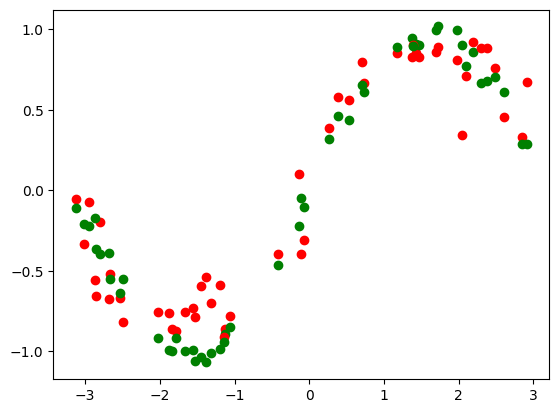

In [5]:
for i in range(10):
    inputs = data.generateInputs()
    outputs = gan.predict(inputs)
    realOutputs = data.generateOutputs(inputs)
    plt.scatter(inputs, outputs, color = "red")
    plt.scatter(inputs, realOutputs, color = "green")
plt.show()